--- Initialization + Data ---

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.optimizers import SGD

%matplotlib inline

In [3]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from tensorflow.keras.layers import LSTM

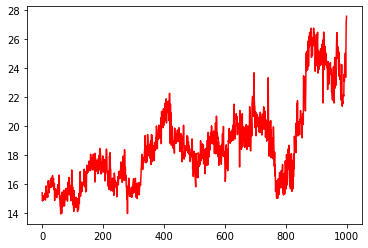

In [4]:
import pandas as pd

csv_file_path = 'close.csv'

df = pd.read_csv(csv_file_path, header=None)

close = df[0].tolist()
logclose = np.log(close).tolist()


plt.plot(close , color = 'r')
plt.show()

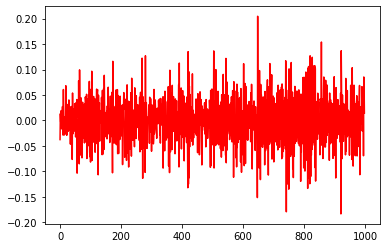

In [ ]:
from math import floor

# Train-test Split
size = len(close)-100
close_train, close_test = close[0:size], close[size:len(close)]
logclose_train, logclose_test = logclose[0:size], logclose[size:len(logclose)]

logreturns = np.diff(logclose).tolist()
logreturns_train, logreturns_test = logreturns[0:size-1], logreturns[size-1:len(logreturns)]

series = logreturns
train = logreturns_train
test = logreturns_test

plt.plot(series , color = 'r')
plt.show()

train = np.array(train).reshape(-1,1)


--- HPO ---

In [ ]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

# Define model 
def make_model(num_layers, neurons, activation, initializer, optimizer, dropout_rate, window_size):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    model = Sequential()
    model.add(Dense(neurons[0], input_dim=window_size, kernel_initializer=initializer, activation=activation))
    model.add(Dropout(dropout_rate))
    for i in range(1, num_layers):
        model.add(Dense(neurons[i], kernel_initializer=initializer, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Define hyperparameter space
space = {
    "window_size": hp.choice("window_size", list(range(2, 20))), 
    "num_layers_choice": hp.choice("num_layers_choice", [
         { 
             "num_layers": 1,
             "neurons": hp.quniform("neurons_1", 2, 299, 1)
         }
    ]),
    "activation": hp.choice("activation", ["sigmoid", "tanh", "relu", "elu"]),
    "initializer": hp.choice("initializer", ["uniform", "glorot_uniform", "he_uniform"]),
    "optimizer": hp.choice("optimizer", ["adam", "sgd", "rmsprop"]),
    "dropout_rate": hp.uniform("dropout_rate", 0.0, 0.5),
    "batch_size": hp.quniform("batch_size", 8, 128, 1)
}
    
# Define HPO objective
def objective(params):
    
    window_size = params["window_size"]

    # Scale training data 
    # In case of the ML approach, the training data for ML are the training set of the Log Returns (i.e. train)
    scaler = RobustScaler()
    train_scaled = scaler.fit_transform(train)

    # Extract parameters from parameter space (allows for three layers)
    arch = params["num_layers_choice"]
    if arch["num_layers"] == 1:
        num_layers = 1
        neurons = [int(arch["neurons"])]
    if arch["num_layers"] == 2:
        num_layers = 2
        neurons = [int(arch["neurons1"]), int(arch["neurons2"])]
    if arch["num_layers"] == 3:
        num_layers = 3
        neurons = [int(arch["neurons1"]), int(arch["neurons2"]), int(arch["neurons3"])]
    activation = params["activation"]
    initializer = params["initializer"]
    optimizer_param = params["optimizer"]
    dropout_rate = params["dropout_rate"]
    batch_size = int(params["batch_size"])
    
    # Apply sliding window technique
    train_X, train_Y = [], []
    for i in range(len(train_scaled) - window_size):
        train_X.append(train_scaled[i:i+window_size])
        train_Y.append(train_scaled[i+window_size])
    new_train_X = np.array([x.reshape(-1) for x in train_X])
    new_train_Y = np.array(train_Y).ravel()
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    epochs = 2000
    validation_split = 0.10
    
    modelKeras = KerasRegressor(
        model=make_model,
        window_size=window_size,
        model__num_layers=num_layers,
        model__neurons=neurons,
        model__activation=activation,
        model__initializer=initializer,
        model__optimizer=optimizer_param,
        model__dropout_rate=dropout_rate,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=callbacks,
        shuffle=False,  
        random_state=42,    
        verbose=0
    )
    
    # Apply cross-validation
    tscv = TimeSeriesSplit(n_splits=2)
    score = np.mean(cross_val_score(modelKeras, new_train_X, new_train_Y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1))

    print(f"Params: {params}, Score: {score:.4f}")

    return {"loss": -score, "status": STATUS_OK}

# Apply HPO and extract most promising model
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42))

best_loss = trials.best_trial['result']['loss']
best_score = best_loss

print("\n------------------------")
print("BEST OVERALL RESULTS:")
print("------------------------")
print("Raw best parameters (indices/values):")
print(best)
print(f"Best score: {best_score:.4f}")

Params: {'activation': 'elu', 'batch_size': 100.0, 'dropout_rate': 0.32587119987444696, 'initializer': 'glorot_uniform', 'num_layers_choice': {'neurons': 186.0, 'num_layers': 1}, 'optimizer': 'rmsprop', 'window_size': 2}, Score: -0.4971
Params: {'activation': 'elu', 'batch_size': 76.0, 'dropout_rate': 0.029968094540700263, 'initializer': 'he_uniform', 'num_layers_choice': {'neurons': 183.0, 'num_layers': 1}, 'optimizer': 'adam', 'window_size': 17}, Score: -0.5482
Params: {'activation': 'relu', 'batch_size': 77.0, 'dropout_rate': 0.07858985028094856, 'initializer': 'uniform', 'num_layers_choice': {'neurons': 24.0, 'num_layers': 1}, 'optimizer': 'adam', 'window_size': 4}, Score: -0.4985
Params: {'activation': 'relu', 'batch_size': 17.0, 'dropout_rate': 0.35223000813752336, 'initializer': 'glorot_uniform', 'num_layers_choice': {'neurons': 65.0, 'num_layers': 1}, 'optimizer': 'sgd', 'window_size': 13}, Score: -0.5157
Params: {'activation': 'tanh', 'batch_size': 49.0, 'dropout_rate': 0.1730

--- Training of best model ---

In [ ]:
# Extract parameters from most promising model
window_sizes = list(range(2, 20))
activations_list = ["sigmoid", "tanh", "relu", "elu"]
initializers_list = ["uniform", "glorot_uniform", "he_uniform"]
optimizers_list = ["adam", "sgd", "rmsprop"]
best_window_size = window_sizes[ best["window_size"] ]
best_activation = activations_list[ best["activation"] ]
best_initializer = initializers_list[ best["initializer"] ]
best_optimizer = optimizers_list[ best["optimizer"] ]
best_dropout_rate = best["dropout_rate"]
best_batch_size = int(best["batch_size"])
if best["num_layers_choice"] == 0:
    best_num_layers = 1
    best_neurons = [int(best["neurons_1"])]
if best["num_layers_choice"] == 1:
    best_num_layers = 2
    best_neurons = [int(best["neurons_2_1"]), int(best["neurons_2_2"])]
if best["num_layers_choice"] == 2:
    best_num_layers = 3
    best_neurons = [int(best["neurons_3_1"]), int(best["neurons_3_2"]), int(best["neurons_3_3"])]

# Scale training data
scaler = RobustScaler()
train_scaled = scaler.fit_transform(train)

# Apply sliding window technique
train_X, train_Y = [], []
for i in range(0, len(train_scaled) - best_window_size):
    train_X.append(train_scaled[i:i+best_window_size])
    train_Y.append(train_scaled[i+best_window_size])
new_train_X = np.array([x.reshape(-1) for x in train_X])
new_train_Y = np.array(train_Y).ravel()

# Construct most promising model
final_model = make_model(
    num_layers=best_num_layers,
    neurons=best_neurons,
    activation=best_activation,
    initializer=best_initializer,
    optimizer=best_optimizer,
    dropout_rate=best_dropout_rate,
    window_size=best_window_size
)

# Train most promising model
fit = final_model.fit(new_train_X, new_train_Y,
                batch_size=best_batch_size,
                epochs=2000,
                validation_split=0.10,
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                shuffle=False,  
                verbose=1)



Epoch 1/2000
12/12 [==============================] - 0s 15ms/step - loss: 0.5945 - val_loss: 0.7862
Epoch 2/2000
12/12 [==============================] - 0s 2ms/step - loss: 0.5646 - val_loss: 0.7297
Epoch 3/2000
12/12 [==============================] - 0s 2ms/step - loss: 0.5103 - val_loss: 0.6971
Epoch 4/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.5083 - val_loss: 0.6728
Epoch 5/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.5028 - val_loss: 0.6557
Epoch 6/2000
12/12 [==============================] - 0s 1ms/step - loss: 0.4677 - val_loss: 0.6386
Epoch 7/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.4721 - val_loss: 0.6306
Epoch 8/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.4476 - val_loss: 0.6238
Epoch 9/2000
12/12 [==============================] - 0s 1ms/step - loss: 0.4446 - val_loss: 0.6206
Epoch 10/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.4556 - val_loss: 0.616

In [9]:
print(best_window_size)
print(best_activation)
print(best_initializer)
print(best_optimizer)
print(best_dropout_rate)
print(best_batch_size) 
print(best_neurons) 

4
relu
glorot_uniform
rmsprop
0.447654510268093
69
[62]


In [10]:
window_size = best_window_size
model = final_model

--- Training Residual Calculations ---

28/28 [==============================] - 0s 506us/step


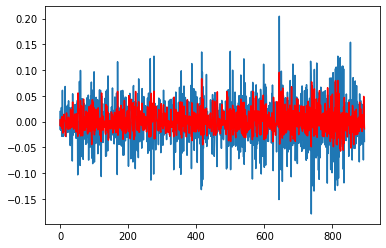

Train MSE: 0.001673


In [ ]:
# Make forecasts on the scaled training set and invert scaling transform
predictions = model.predict(new_train_X)
predictions_rescaled=scaler.inverse_transform(predictions.reshape(-1, 1))
Y = pd.DataFrame(train[window_size:])
pred = pd.DataFrame(predictions_rescaled)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(train[window_size:],predictions_rescaled)
print('Train MSE: %.6f' % error)

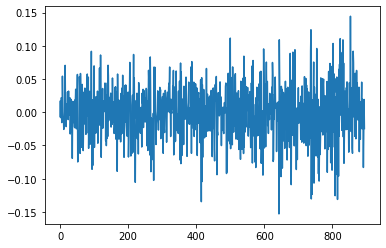

In [ ]:
# Calculate training residuals of SYSID-ML model
rawResiduals_FNN = Y - pred
plt.plot(rawResiduals_FNN)
plt.show()

rawResiduals_FNN.to_csv('rawResiduals_FNN_BO-TPE_robustscaler.csv', index=False)

--- Forecasting on test set ---

4/4 [==============================] - 0s 329us/step


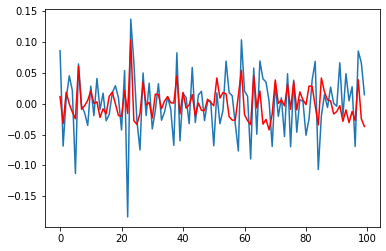

Test MSE: 0.001883


In [ ]:
# Add presamples from training set to test set
# In case of the ML approach:
    # -the training set for the ML model is the training set of the Log Returns in train
    # -the test set for the ML model is the test set of the Log Returns in test
test_extended = train.tolist()[-1*window_size:] + test
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)

# Scale test set with scaling transformation that was fitted on the training data
test_scaled = scaler.transform(test_data)

# Apply sliding window technique
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)

# Make forecasts on the scaled test set and apply inverse scaling transformation
predictions = model.predict(new_test_X)
predictions_rescaled=scaler.inverse_transform(predictions)
predictions_rescaled = predictions_rescaled.flatten().tolist()

Y = pd.DataFrame(test)
pred = pd.DataFrame(predictions_rescaled)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(test,predictions_rescaled)
print('Test MSE: %.6f' % error)

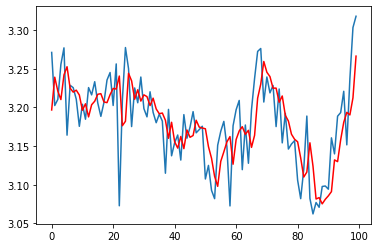

Test MSE: 0.001883


In [ ]:
# Calculate Log Close forecasts from Log Return forecasts

predicted_log_prices = np.zeros(len(logclose_test)) 
predicted_log_prices[0] = logclose_train[-1] + predictions_rescaled[0]

for t in range(1, len(logclose_test)):
    predicted_log_prices[t] = logclose_test[t-1] + predictions_rescaled[t] 


Y = pd.DataFrame(logclose_test)
pred = pd.DataFrame(predicted_log_prices)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()

error = mse(logclose_test,predicted_log_prices)
print('Test MSE: %.6f' % error)

In [ ]:
# Apply forecasting metrics on Log Close predictions
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on logclose: ")
print(compute_error_metrics(logclose_test, predicted_log_prices))
print(compute_directional_metrics(logclose_test, predicted_log_prices))

Errors on logclose: 
{'NMSE': 0.6133505742017721, 'MAE': 0.034058322301590296, 'RMSE': 0.04338854710400188, 'MSE': 0.0018825660197961903, 'MAPE': 1.0721503996529291, 'TheilsU': 0.8558932437634597}
{'DA': 0.6262626262626263, 'DS': 0.3333333333333333, 'CU': 0.34545454545454546, 'CD': 0.3181818181818182}


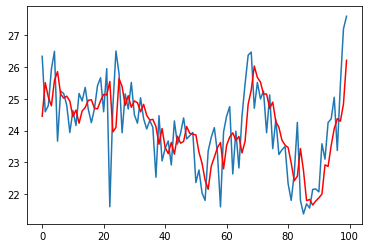

Test MSE: 1.089905


In [ ]:
# Go from Log Close predictions to Close predictions
predicted_prices = np.exp(predicted_log_prices)
Y = pd.DataFrame(close_test)
pred = pd.DataFrame(predicted_prices)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()

error = mse(close_test,predicted_prices)
print('Test MSE: %.6f' % error)

In [ ]:
# Apply forecasting metrics on Close predictions
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on close: ")
print(compute_error_metrics(close_test, predicted_prices))
print(compute_directional_metrics(close_test, predicted_prices))

Errors on close: 
{'NMSE': 0.6158041798567596, 'MAE': 0.8202470630598816, 'RMSE': 1.0439853247957818, 'MSE': 1.0899053583889537, 'MAPE': 3.416042189883887, 'TheilsU': 0.8509129848315424}
{'DA': 0.6262626262626263, 'DS': 0.3333333333333333, 'CU': 0.34545454545454546, 'CD': 0.3181818181818182}


Stock: 26.339 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26339.0
Stock: 24.591 Action: Buy Portfolio: 26336.96 Stocks: 1071 Balance_init: 2 total($) 26338.96
Stock: 24.786 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26547.81
Stock: 25.934 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26547.81
Stock: 26.495 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 26547.81
Stock: 23.666 Action: Buy Portfolio: 26529.59 Stocks: 1121 Balance_init: 18 total($) 26547.59
Stock: 25.243 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28315.4
Stock: 25.166 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 28315.4
Stock: 24.793 Action: Buy Portfolio: 28313.61 Stocks: 1142 Balance_init: 1 total($) 28314.61
Stock: 23.938 Action: Bought--Holding Portfolio: 27337.2 Stocks: 1142 Balance_init: 1 total($) 27338.2
Stock: 24.63

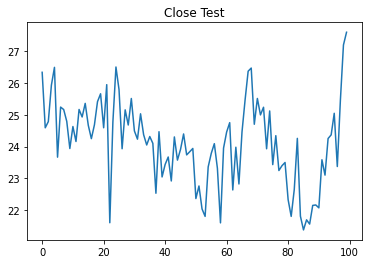

Final value of stock:
27601.0


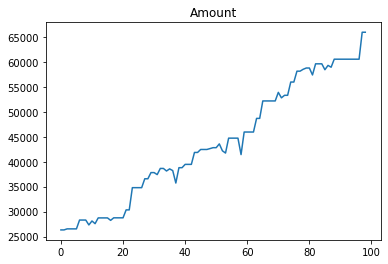

Final value of portfolio:
65910.0
TS=
2.387956958081229


In [ ]:
# Apply trading strategy on Close predictions
import sys
sys.path.append('../Functions/Performance Metrics/')
from trading_strategies import trading_strategy1

trading_strategy1(close_test, predicted_prices)
            


In [19]:
65910.0/(1000*27.601)

2.387956958081229